# Environment

In [106]:
import pandas as pd
import numpy as np
import ddfloww as dd
import scipy as sp
import scipy.stats as stats
import xgboost as xgb
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge


# Acquisition

Created four dataframes of properties and predictions (2016 & 2017). Joined them into a single dataframe which was exported to a csv file in order to facilitate working locally on a single machine. The previous operations ran once and then commented out. The function below reads in the saved `zillow.csv` file.

In [2]:
df = dd.get_zillow()

# Preparation

In [3]:
# Plot styling
plt.style.use('fivethirtyeight')

Let's take a peek at the dataframe and summarize.

In [4]:
dd.summarize_data(df)
df.shape

HEAD
   parcelid  logerror transactiondate       id  airconditioningtypeid  \
0  11016594    0.0276      2016-01-01  2931667                    1.0   
1  14366692   -0.1684      2016-01-01   475764                    NaN   
2  12098116   -0.0040      2016-01-01  2444575                    1.0   
3  12643413    0.0218      2016-01-02  1584730                    1.0   
4  14432541   -0.0050      2016-01-02  2926916                    NaN   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                       NaN           NaN          2.0         3.0   
1                       NaN           NaN          3.5         4.0   
2                       NaN           NaN          3.0         2.0   
3                       NaN           NaN          2.0         2.0   
4                       NaN           NaN          2.5         4.0   

   buildingclasstypeid         ...           taxdelinquencyflag  \
0                  NaN         ...                          NaN   
1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 68 columns):
parcelid                        167888 non-null int64
logerror                        167888 non-null float64
transactiondate                 167888 non-null object
id                              167888 non-null int64
airconditioningtypeid           53788 non-null float64
architecturalstyletypeid        468 non-null float64
basementsqft                    93 non-null float64
bathroomcnt                     167854 non-null float64
bedroomcnt                      167854 non-null float64
buildingclasstypeid             31 non-null float64
buildingqualitytypeid           107173 non-null float64
calculatedbathnbr               166056 non-null float64
decktypeid                      1272 non-null float64
finishedfloor1squarefeet        12893 non-null float64
calculatedfinishedsquarefeet    166992 non-null float64
finishedsquarefeet12            159519 non-null float64
finishedsquar

(36.418, 802.1]     2060
(802.1, 1560.2]     7216
(1560.2, 2318.3]    2753
(2318.3, 3076.4]     550
(3076.4, 3834.5]     187
(3834.5, 4592.6]      78
(4592.6, 5350.7]      28
(5350.7, 6108.8]      10
(6108.8, 6866.9]       8
(6866.9, 7625.0]       3
Name: finishedfloor1squarefeet, dtype: int64


calculatedfinishedsquarefeet:
(-33.638999999999996, 3565.8]    159086
(3565.8, 7129.6]                   7523
(7129.6, 10693.4]                   337
(10693.4, 14257.2]                   30
(14257.2, 17821.0]                    8
(17821.0, 21384.8]                    5
(21384.8, 24948.6]                    2
(24948.6, 28512.4]                    0
(28512.4, 32076.2]                    0
(32076.2, 35640.0]                    1
Name: calculatedfinishedsquarefeet, dtype: int64


finishedsquarefeet12:
(-19.928, 2194.7]     125263
(2194.7, 4387.4]       31355
(4387.4, 6580.1]        2369
(6580.1, 8772.8]         402
(8772.8, 10965.5]         89
(10965.5, 13158.2]        24
(13158.2, 15350.9]        

regionidzip:
(95678.306, 126351.3]    167744
(126351.3, 156720.6]          0
(156720.6, 187089.9]          0
(187089.9, 217459.2]          0
(217459.2, 247828.5]          0
(247828.5, 278197.8]          0
(278197.8, 308567.1]          0
(308567.1, 338936.4]          0
(338936.4, 369305.7]          0
(369305.7, 399675.0]         25
Name: regionidzip, dtype: int64


roomcnt:
(-0.019, 1.8]    129670
(1.8, 3.6]          508
(3.6, 5.4]         9605
(5.4, 7.2]        18208
(7.2, 9.0]         8837
(9.0, 10.8]         704
(10.8, 12.6]        287
(12.6, 14.4]         31
(14.4, 16.2]          3
(16.2, 18.0]          1
Name: roomcnt, dtype: int64


storytypeid:
NaN     167795
 7.0        93
Name: storytypeid, dtype: int64


threequarterbathnbr:
NaN     145773
 1.0     21934
 2.0       165
 3.0        14
 7.0         1
 4.0         1
Name: threequarterbathnbr, dtype: int64


typeconstructiontypeid:
NaN      167366
 6.0        516
 4.0          3
 13.0         2
 10.0         1
Name: typeconstructi

(167888, 68)

Aggressively reduce number of column variables:

1. Columns and (subsequently) rows were removed if their number of missing values exceeds the threshold of 50% for columns and 75% for rows.
1. Columns that are redundant or add no value were also removed.
1. Certain rows were removed if the given columns' values are null.
1. Estimated single-unit dwellings were estimated and filtered in.

In [5]:
df = dd.prep_zillow(df,
                    preq_col=.5,
                    preq_row=.6,
                    cols_to_remove=['parcelid',
                                    'id',
                                    'finishedsquarefeet12',
                                    'fips',
                                    'heatingorsystemtypeid',
                                    'propertylandusetypeid',
                                    'rawcensustractandblock',
                                    'regionidcity',
                                    'roomcnt',
                                    'assessmentyear',
                                    'censustractandblock',
                                    'structuretaxvaluedollarcnt',
                                    'taxvaluedollarcnt',
                                    'propertycountylandusecode',
                                    'propertycountylandusecode',
                                    'propertylandusetypeid',
                                    'propertyzoningdesc',],
                    cols_to_validate=['latitude', 'longitude'])

Impute the values in land square feet using linear regression with landtaxvaluedollarcnt as x and estimated land square feet as y.

In [6]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

140750    0.025729
121406    0.062776
122134    0.003269
118154    0.023493
129610    0.078992
112058    0.259014
149829    0.039668
96452     0.006707
133685    0.093032
35410     0.099800
Name: logerror, dtype: float64

In [7]:
df = dd.impute_missing(df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[32683.87758287]
[[-0.01046837]]
Univariate - final_exam = b + m * exam1
    y-intercept (b): 32683.88
    coefficient (m): -0.01



In [8]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0            0.000000          0   
transactiondate                         0            0.000000          0   
bathroomcnt                             0            0.000000          0   
bedroomcnt                              0            0.000000          0   
buildingqualitytypeid               56590           34.809620          0   
calculatedbathnbr                     112            0.068893          0   
calculatedfinishedsquarefeet           26            0.015993          0   
fullbathcnt                           112            0.068893          0   
latitude                                0            0.000000          0   
longitude                               0            0.000000          0   
lotsizesquarefeet                       0            0.000000          0   
regionidcounty                          0            0.000000          0   
regionidzip                            58            0.035677          0   
unitcnt                             55366           34.056714          0   
yearbuilt                             133            0.081811          0   
landtaxvaluedollarcnt                   2            0.001230          0   
taxamount                              11            0.006766          0   
propertylandusedesc                     0            0.000000          0   
heatingorsystemdesc                 57129           35.141170          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0             0.0  
transactiondate                            0.0          0             0.0  
bathroomcnt                                0.0          0             0.0  
bedroomcnt                                 0.0          0             0.0  
buildingqualitytypeid                      0.0          0             0.0  
calculatedbathnbr                          0.0          0             0.0  
calculatedfinishedsquarefeet               0.0          0             0.0  
fullbathcnt                                0.0          0             0.0  
latitude                                   0.0          0             0.0  
longitude                                  0.0          0             0.0  
lotsizesquarefeet                          0.0          0             0.0  
regionidcounty                             0.0          0             0.0  
regionidzip                                0.0          0             0.0  
unitcnt                                    0.0          0             0.0  
yearbuilt                                  0.0          0             0.0  
landtaxvaluedollarcnt                      0.0          0             0.0  
taxamount                                  0.0          0             0.0  
propertylandusedesc                        0.0          0             0.0  
heatingorsystemdesc                        0.0          0             0.0

In [9]:
df = dd.fill_with_median(df, ['buildingqualitytypeid', 'unitcnt', 'yearbuilt'])

In [10]:
df = dd.fill_with_none(df, 'heatingorsystemdesc')

In [11]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0            0.000000          0   
transactiondate                         0            0.000000          0   
bathroomcnt                             0            0.000000          0   
bedroomcnt                              0            0.000000          0   
buildingqualitytypeid                   0            0.000000          0   
calculatedbathnbr                     112            0.068893          0   
calculatedfinishedsquarefeet           26            0.015993          0   
fullbathcnt                           112            0.068893          0   
latitude                                0            0.000000          0   
longitude                               0            0.000000          0   
lotsizesquarefeet                       0            0.000000          0   
regionidcounty                          0            0.000000          0   
regionidzip                            58            0.035677          0   
unitcnt                                 0            0.000000          0   
yearbuilt                               0            0.000000          0   
landtaxvaluedollarcnt                   2            0.001230          0   
taxamount                              11            0.006766          0   
propertylandusedesc                     0            0.000000          0   
heatingorsystemdesc                     0            0.000000          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0             0.0  
transactiondate                            0.0          0             0.0  
bathroomcnt                                0.0          0             0.0  
bedroomcnt                                 0.0          0             0.0  
buildingqualitytypeid                      0.0          0             0.0  
calculatedbathnbr                          0.0          0             0.0  
calculatedfinishedsquarefeet               0.0          0             0.0  
fullbathcnt                                0.0          0             0.0  
latitude                                   0.0          0             0.0  
longitude                                  0.0          0             0.0  
lotsizesquarefeet                          0.0          0             0.0  
regionidcounty                             0.0          0             0.0  
regionidzip                                0.0          0             0.0  
unitcnt                                    0.0          0             0.0  
yearbuilt                                  0.0          0             0.0  
landtaxvaluedollarcnt                      0.0          0             0.0  
taxamount                                  0.0          0             0.0  
propertylandusedesc                        0.0          0             0.0  
heatingorsystemdesc                        0.0          0             0.0

In [12]:
dd.missing_values_row(df)

num_missing  percentage
0                 0         0.0
1                 0         0.0
2                 0         0.0
3                 0         0.0
4                 0         0.0
5                 0         0.0
6                 0         0.0
7                 0         0.0
8                 0         0.0
9                 0         0.0
10                0         0.0
11                0         0.0
12                0         0.0
13                0         0.0
14                0         0.0
15                0         0.0
16                0         0.0
17                0         0.0
18                0         0.0
19                0         0.0
20                0         0.0
21                0         0.0
22                0         0.0
23                0         0.0
24                0         0.0
25                0         0.0
26                0         0.0
27                0         0.0
28                0         0.0
29                0         0.0
...             ...         ...
167857            0         0.0
167858            0         0.0
167859            0         0.0
167860            0         0.0
167861            0         0.0
167862            0         0.0
167863            0         0.0
167864            0         0.0
167865            0         0.0
167866            0         0.0
167867            0         0.0
167868            0         0.0
167869            0         0.0
167870            0         0.0
167871            0         0.0
167873            0         0.0
167874            0         0.0
167875            0         0.0
167876            0         0.0
167877            0         0.0
167878            0         0.0
167879            0         0.0
167880            0         0.0
167881            0         0.0
167882            0         0.0
167883            0         0.0
167884            0         0.0
167885            0         0.0
167886            0         0.0
167887            0         0.0

[162570 rows x 2 columns]

Let's check data types.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null float64
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null float64
regionidzip                     162512 non-null float64
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null float64
landtaxvaluedollarcnt           162568 non-null fl

Convert column variables into their proper data type.

In [14]:
df = dd.convert_to_string(df,
                          'buildingqualitytypeid',
                          'regionidcounty',
                          'regionidzip',)

In [15]:
df = dd.convert_to_int(df, 'yearbuilt')

Check colummn variables for the correct data type after `astype()` conversions.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null object
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null object
regionidzip                     162570 non-null object
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null int64
landtaxvaluedollarcnt           162568 non-null float64

Now, let's check for some outliers.

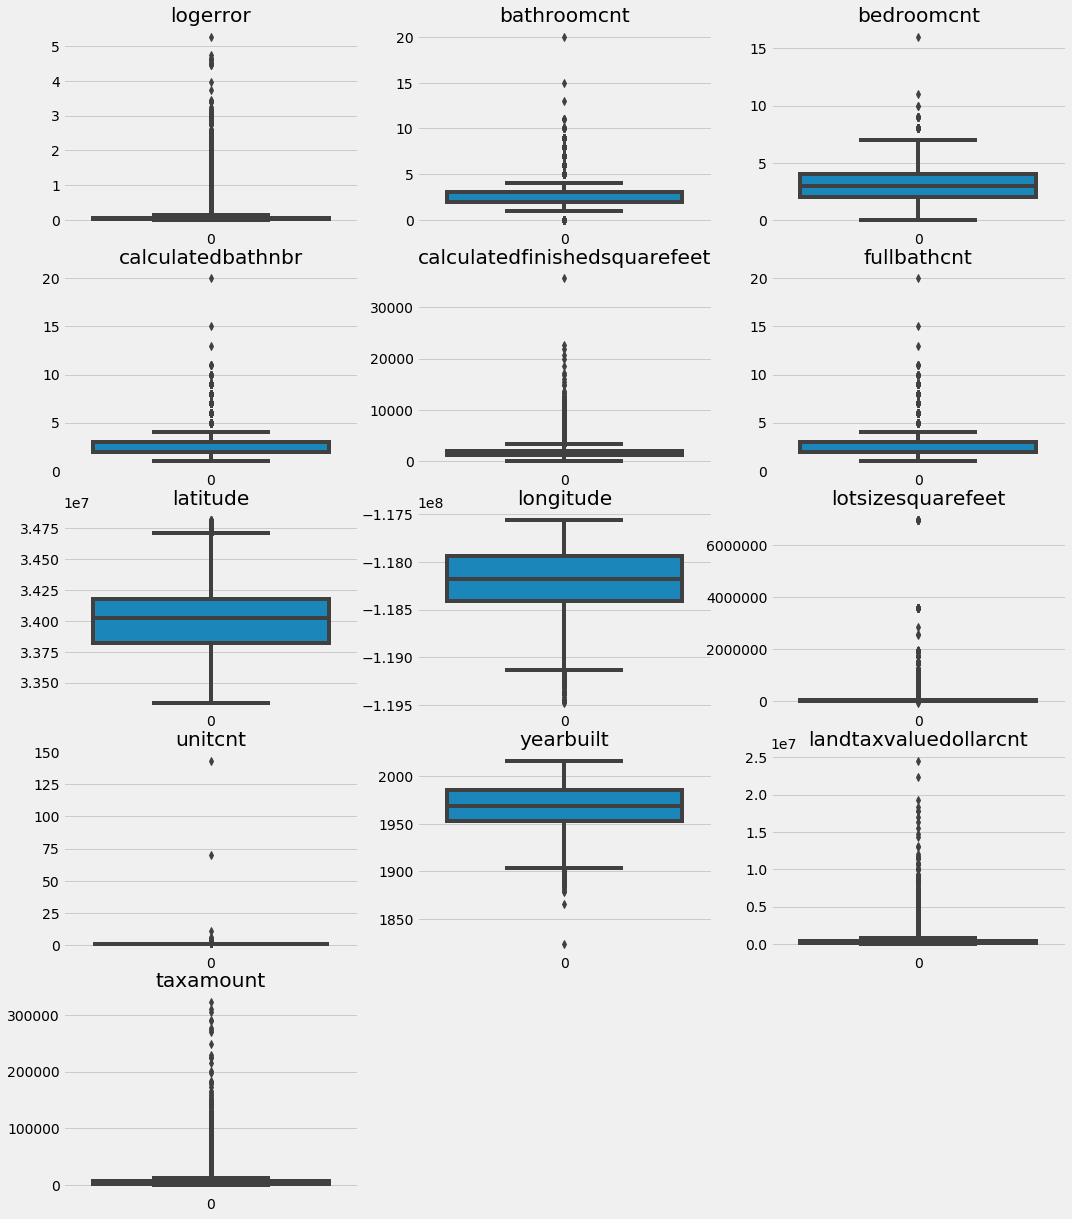

In [17]:
dd.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

Now, let's remove the outliers.

In [18]:
# Remove outliers and nonsensical observations
# TODO: do this using function with selectable method.
df = df[df.bathroomcnt <= 15]
df = df[df.bedroomcnt <= 13]
df = df[df.calculatedbathnbr <= 15]
df = df[df.calculatedfinishedsquarefeet <= 14000]
df = df[df.fullbathcnt <= 15]
df = df[df.latitude >= 33500000]
df = df[df.lotsizesquarefeet <= 2000000]
df = df[df.unitcnt <= 1]
df = df[df.landtaxvaluedollarcnt <= 20000000]

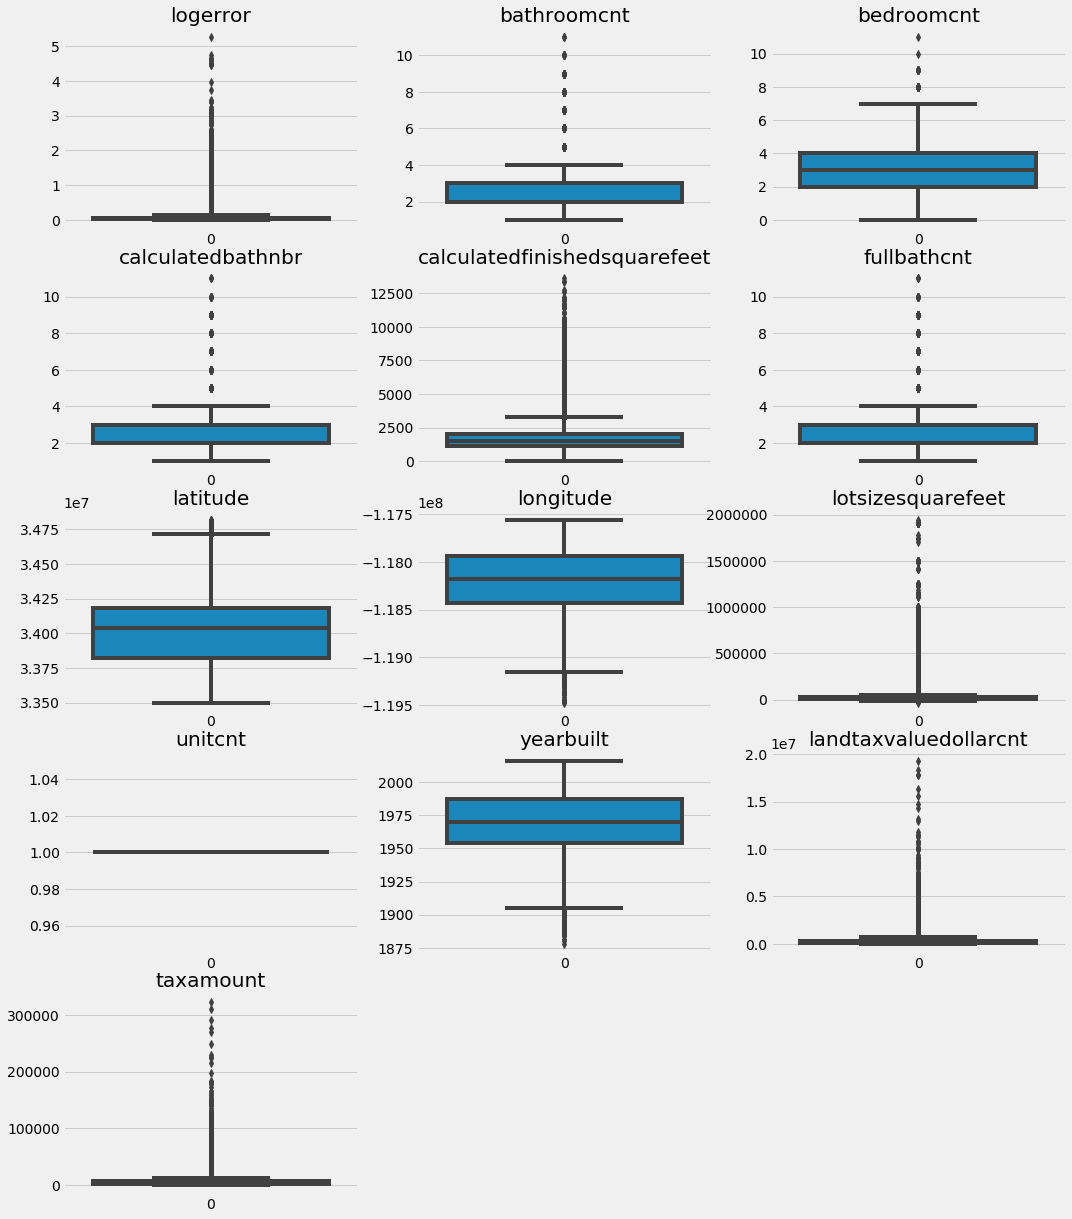

In [19]:
dd.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

'unitcnt' can now be removed since all observations share the same value.

In [20]:
df = df.drop(columns='unitcnt')
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

In [21]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0             0.00000          0   
transactiondate                         0             0.00000          0   
bathroomcnt                             0             0.00000          0   
bedroomcnt                              0             0.00000          0   
buildingqualitytypeid                   0             0.00000          0   
calculatedbathnbr                       0             0.00000          0   
calculatedfinishedsquarefeet            0             0.00000          0   
fullbathcnt                             0             0.00000          0   
latitude                                0             0.00000          0   
longitude                               0             0.00000          0   
lotsizesquarefeet                       0             0.00000          0   
regionidcounty                          0             0.00000          0   
regionidzip                             0             0.00000          0   
yearbuilt                               0             0.00000          0   
landtaxvaluedollarcnt                   0             0.00000          0   
taxamount                              10             0.00647          0   
propertylandusedesc                     0             0.00000          0   
heatingorsystemdesc                     0             0.00000          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0        0.000000  
transactiondate                            0.0          0        0.000000  
bathroomcnt                                0.0          0        0.000000  
bedroomcnt                                 0.0          0        0.000000  
buildingqualitytypeid                      0.0          0        0.000000  
calculatedbathnbr                          0.0          0        0.000000  
calculatedfinishedsquarefeet               0.0          0        0.000000  
fullbathcnt                                0.0          0        0.000000  
latitude                                   0.0          0        0.000000  
longitude                                  0.0          0        0.000000  
lotsizesquarefeet                          0.0          0        0.000000  
regionidcounty                             0.0          0        0.000000  
regionidzip                                0.0         58        0.037527  
yearbuilt                                  0.0          0        0.000000  
landtaxvaluedollarcnt                      0.0          0        0.000000  
taxamount                                  0.0          0        0.000000  
propertylandusedesc                        0.0          0        0.000000  
heatingorsystemdesc                        0.0          0        0.000000

In [22]:
df = dd.validate_cols(df, ['taxamount'])

In [23]:
dd.missing_values_col(df)

num_missing  missing_percentage  num_empty  \
logerror                                0                 0.0          0   
transactiondate                         0                 0.0          0   
bathroomcnt                             0                 0.0          0   
bedroomcnt                              0                 0.0          0   
buildingqualitytypeid                   0                 0.0          0   
calculatedbathnbr                       0                 0.0          0   
calculatedfinishedsquarefeet            0                 0.0          0   
fullbathcnt                             0                 0.0          0   
latitude                                0                 0.0          0   
longitude                               0                 0.0          0   
lotsizesquarefeet                       0                 0.0          0   
regionidcounty                          0                 0.0          0   
regionidzip                             0                 0.0          0   
yearbuilt                               0                 0.0          0   
landtaxvaluedollarcnt                   0                 0.0          0   
taxamount                               0                 0.0          0   
propertylandusedesc                     0                 0.0          0   
heatingorsystemdesc                     0                 0.0          0   

                              empty_percentage  nan_count  nan_percentage  
logerror                                   0.0          0         0.00000  
transactiondate                            0.0          0         0.00000  
bathroomcnt                                0.0          0         0.00000  
bedroomcnt                                 0.0          0         0.00000  
buildingqualitytypeid                      0.0          0         0.00000  
calculatedbathnbr                          0.0          0         0.00000  
calculatedfinishedsquarefeet               0.0          0         0.00000  
fullbathcnt                                0.0          0         0.00000  
latitude                                   0.0          0         0.00000  
longitude                                  0.0          0         0.00000  
lotsizesquarefeet                          0.0          0         0.00000  
regionidcounty                             0.0          0         0.00000  
regionidzip                                0.0         58         0.03753  
yearbuilt                                  0.0          0         0.00000  
landtaxvaluedollarcnt                      0.0          0         0.00000  
taxamount                                  0.0          0         0.00000  
propertylandusedesc                        0.0          0         0.00000  
heatingorsystemdesc                        0.0          0         0.00000

# Exploration

Let's plot the logerror and its distribution.

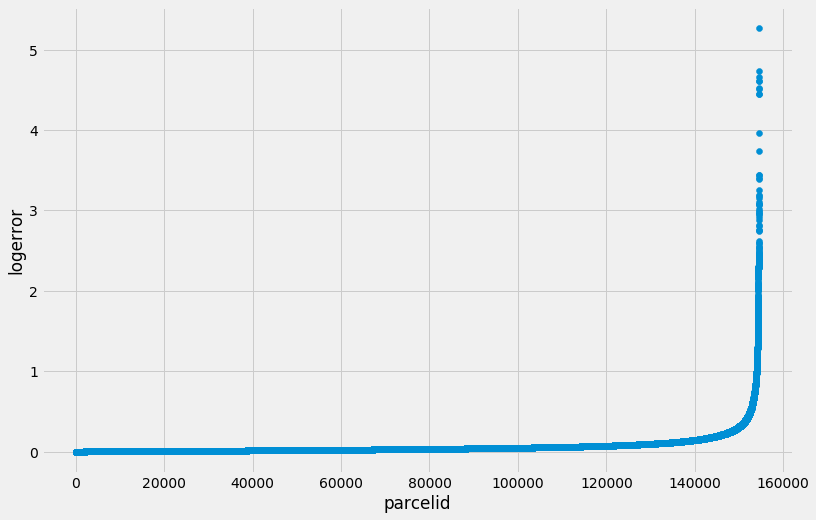

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


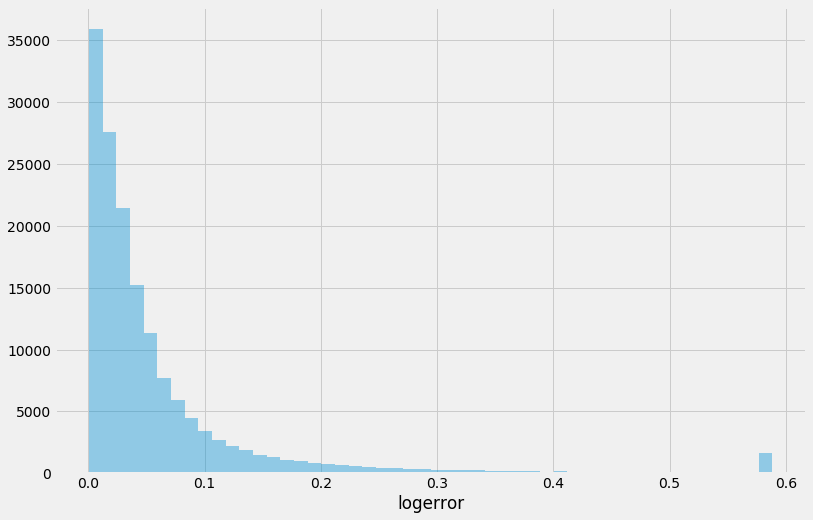

In [24]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

In [25]:
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

Let's create a variable to hold a list of numerical variables.

In [26]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'landtaxvaluedollarcnt',
 'taxamount']

Let's create a variable to hold a list of non-numerical variables.

In [27]:
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
cat_cols

['transactiondate',
 'buildingqualitytypeid',
 'regionidcounty',
 'regionidzip',
 'propertylandusedesc',
 'heatingorsystemdesc']

Let's save a copy of the dataframe before standardizing.

In [28]:
df_normal = df.copy()

Let's use minmax scaling to standardize applicable variables.

In [29]:
df = dd.standardize_data(df, columns=['logerror',
                                      'bathroomcnt',
                                      'bedroomcnt',
                                      'calculatedbathnbr',
                                      'calculatedfinishedsquarefeet',
                                      'latitude',
                                      'longitude',
                                      'lotsizesquarefeet',
                                      'yearbuilt',
                                      'landtaxvaluedollarcnt',
                                      'taxamount'])

Let's see the distribution of some variables.

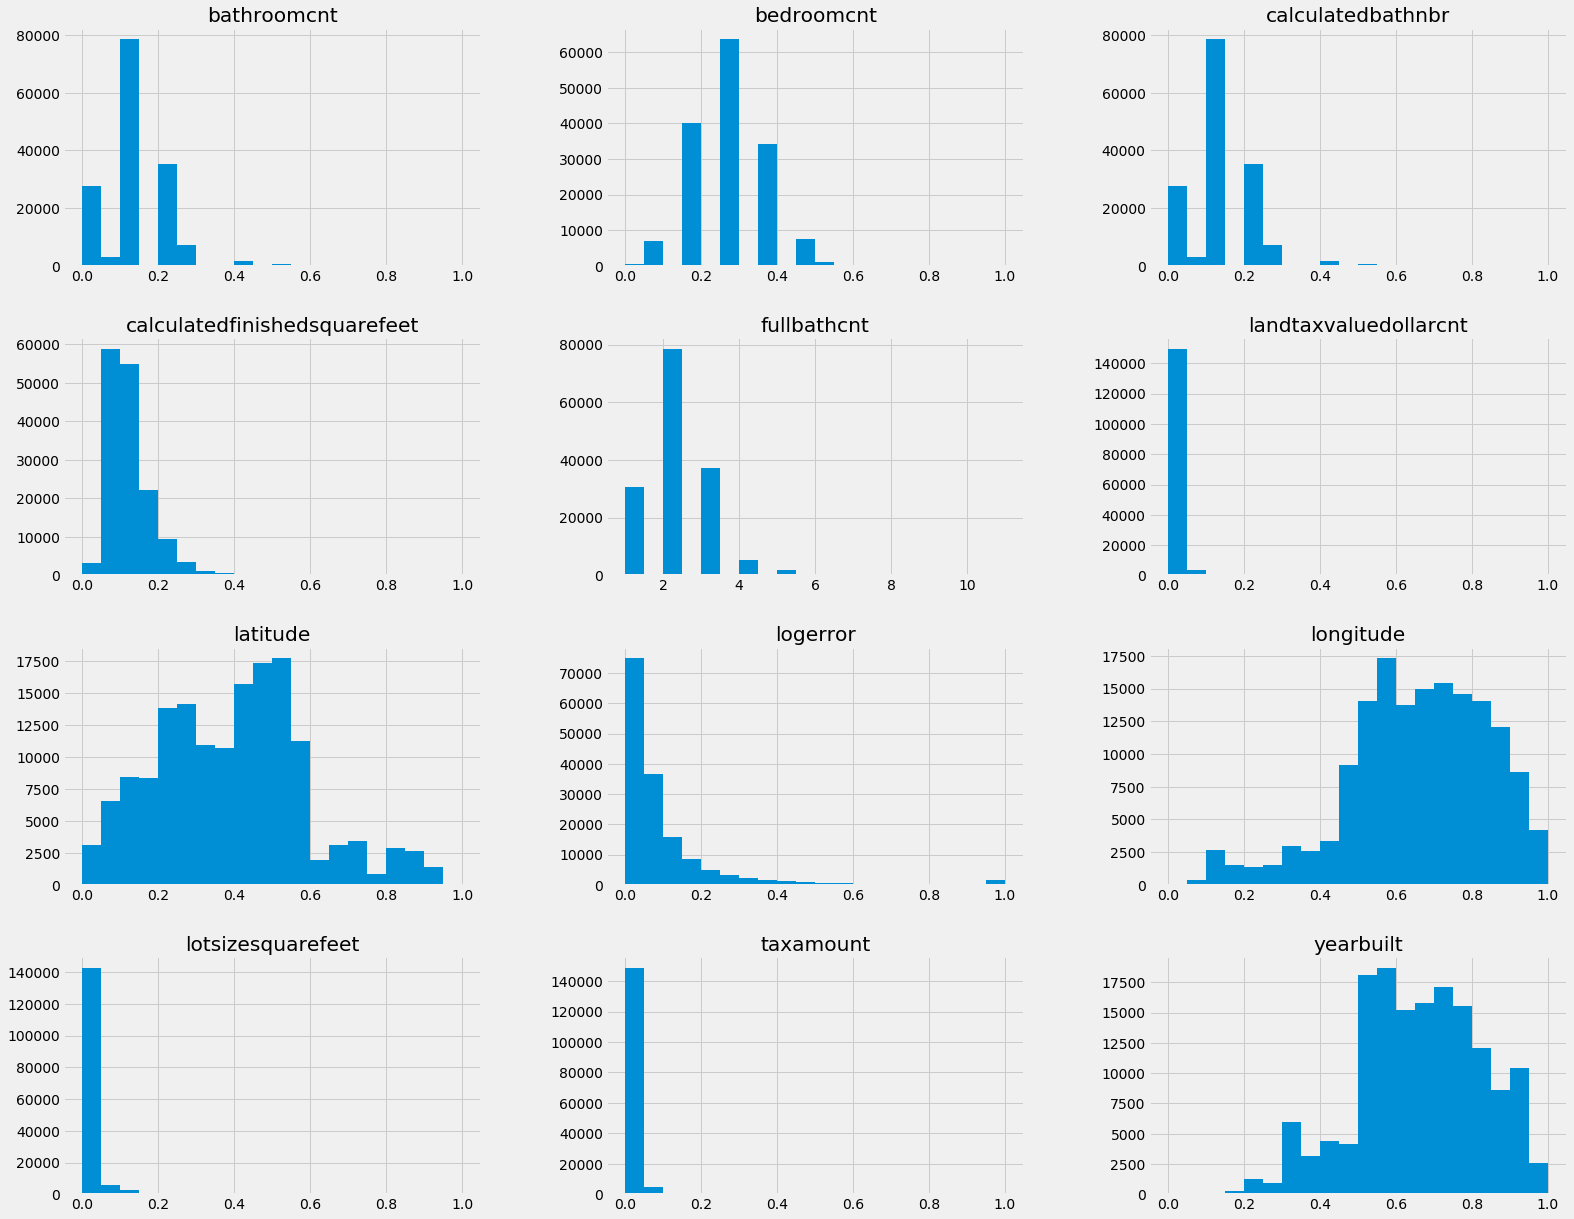

In [30]:
dd.plot_hist(df)

Let's now generate a pairplot to see how our variables interact with each other.

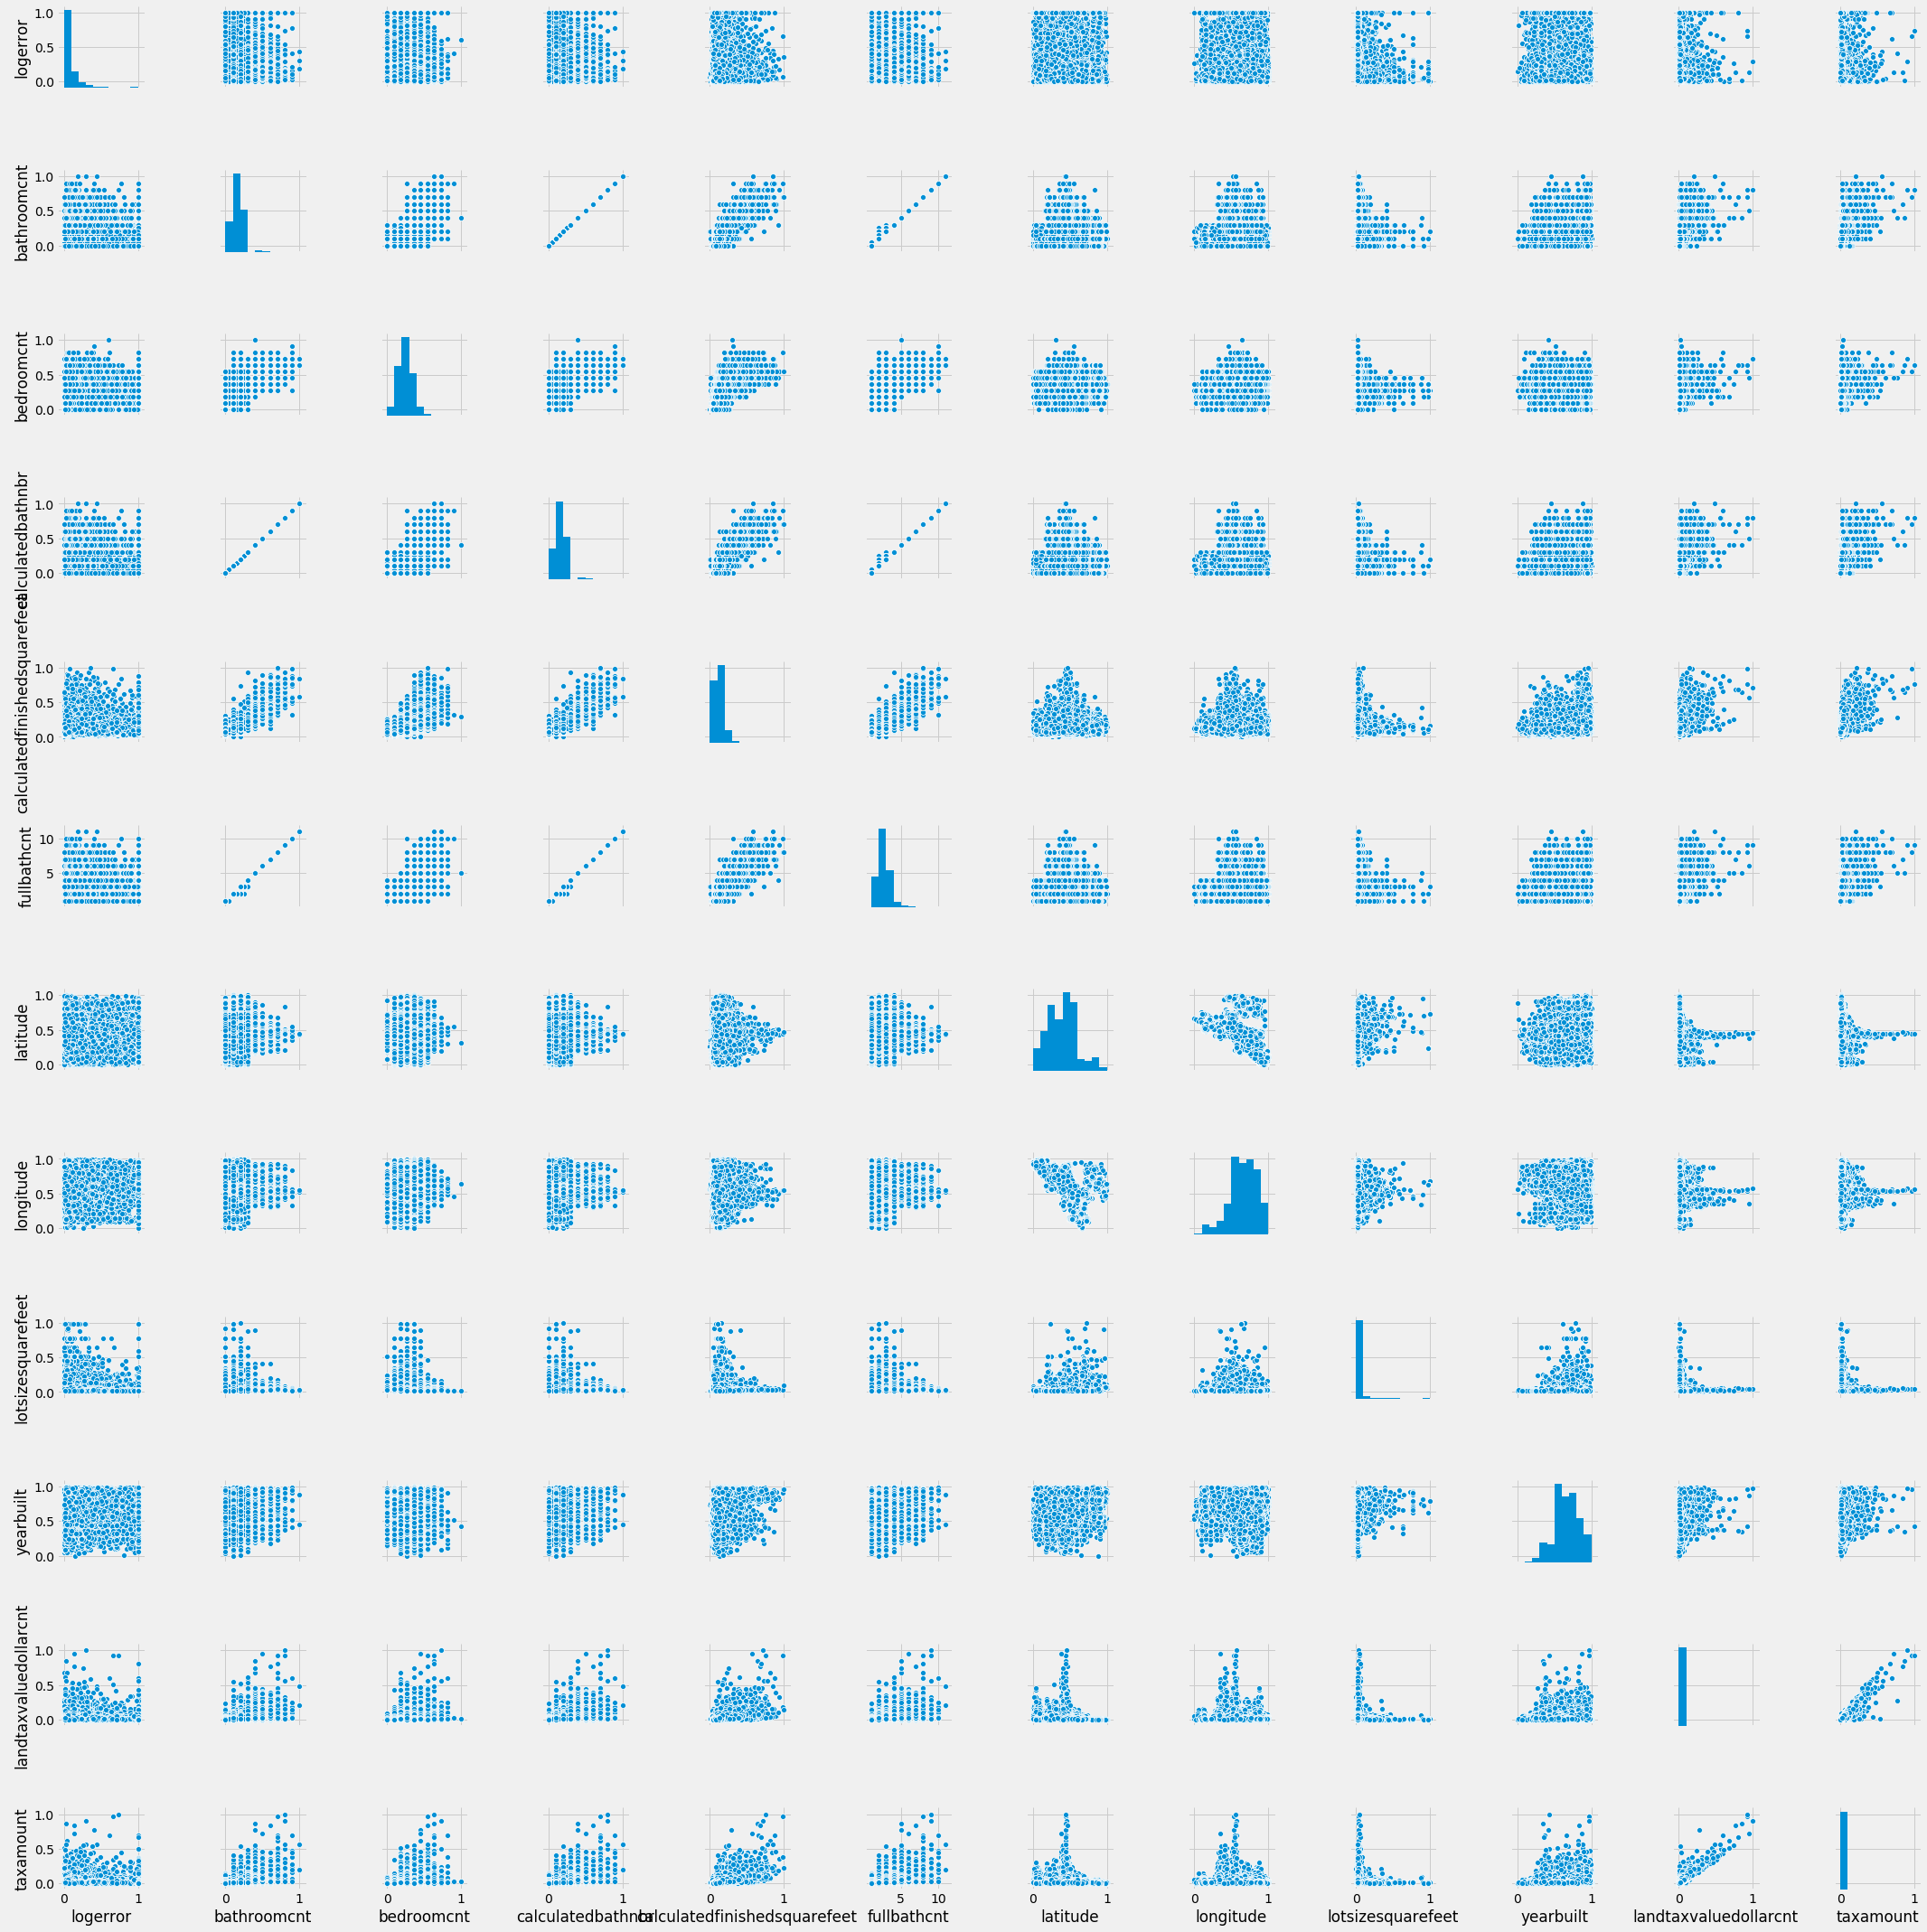

In [31]:
sns.pairplot(df, vars=num_cols)

And a heatmap to see the correlation of variables.

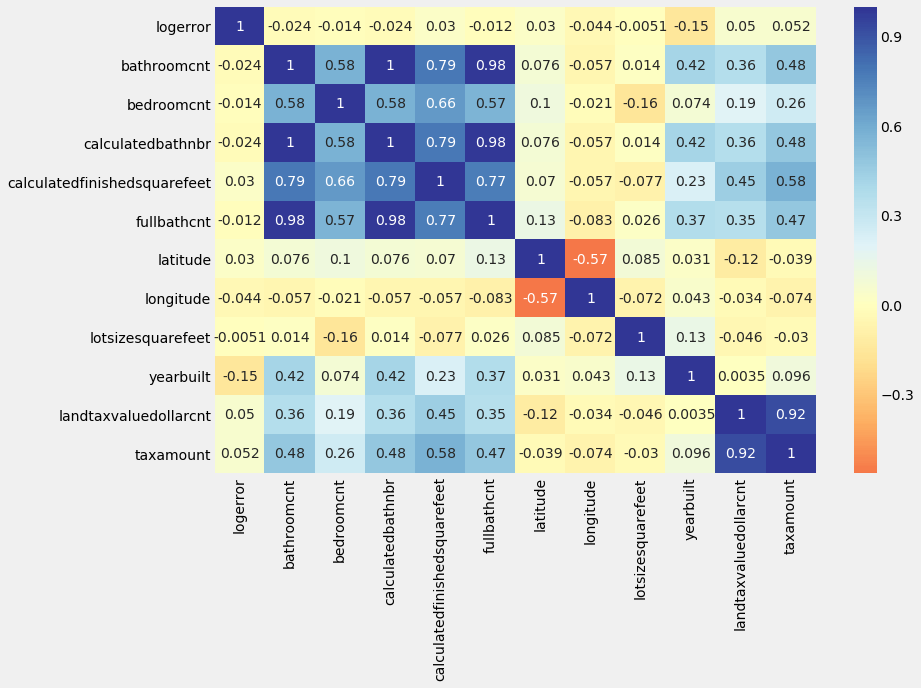

In [32]:
df_heat = df[num_cols]
dd.plot_heat(df_heat)

Let's remove redundant variables some more.

In [33]:
df = dd.remove_columns(df, cols_to_remove=['calculatedbathnbr',
                                           'fullbathcnt',
                                           'landtaxvaluedollarcnt'])
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

Let's concentrate on single-unit dwellings...

In [34]:
df.propertylandusedesc.value_counts()

Single Family Residential                     108320
Condominium                                    41079
Planned Unit Development                        4132
Cluster Home                                     691
Mobile Home                                      126
Cooperative                                       57
Duplex (2 Units, Any Combination)                 50
Manufactured, Modular, Prefabricated Homes        37
Residential General                               29
Townhouse                                         17
Triplex (3 Units, Any Combination)                 6
Name: propertylandusedesc, dtype: int64

and narrow them down accordingly:

In [35]:
df = df.loc[(df['propertylandusedesc'] == 'Single Family Residential') |
                (df['propertylandusedesc'] == 'Condominium') |
                (df['propertylandusedesc'] == 'Residential General') |
                (df['propertylandusedesc'] == 'Townhouse')
               ]



In [36]:
df.propertylandusedesc.value_counts()

Single Family Residential    108320
Condominium                   41079
Residential General              29
Townhouse                        17
Name: propertylandusedesc, dtype: int64

In [37]:
dd.summarize_data(df)

HEAD
   logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusede

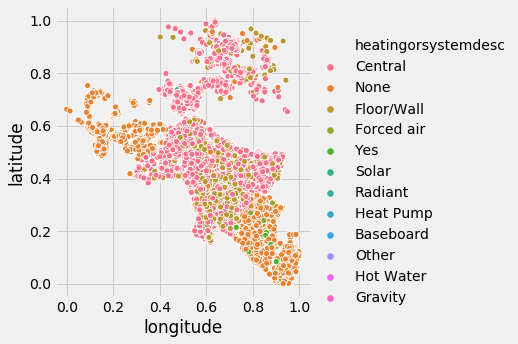

In [38]:
dd.plot_rel(df, 'longitude', 'latitude', 'heatingorsystemdesc')

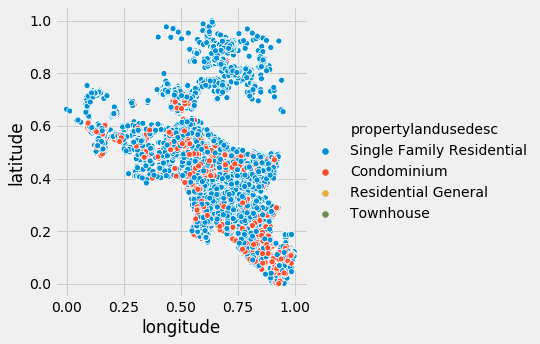

In [39]:
dd.plot_rel(df, 'longitude', 'latitude', 'propertylandusedesc')

In [40]:
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

In [41]:
df_xgb_x = df[num_cols].drop(columns=['logerror'])

In [42]:
fn = df_xgb_x.columns.values

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


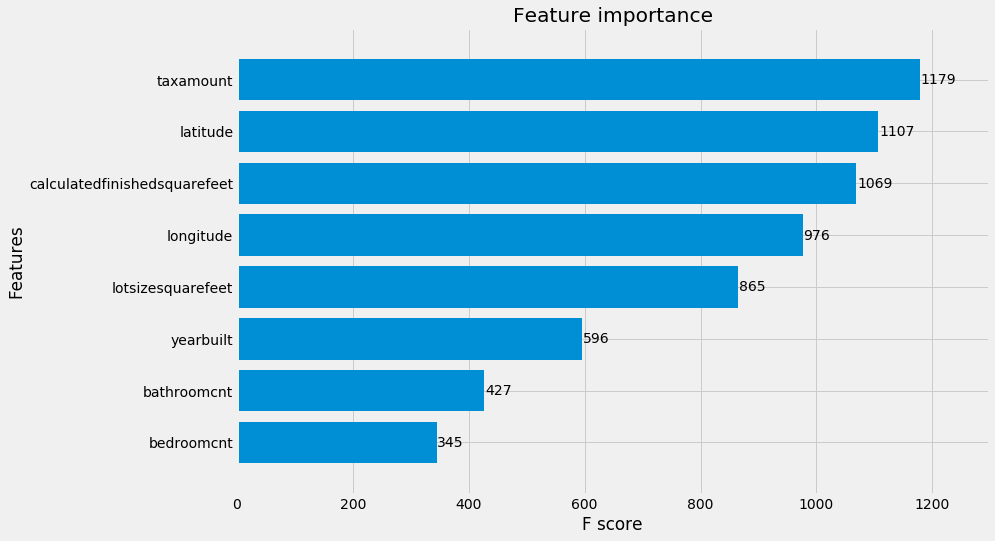

In [43]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(df_xgb_x, df.logerror, feature_names=fn)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Clustering

### Cluster 1 - logerror

In [44]:
df_c1 = df[['logerror']]

   k          sse
0  1  3540.259710
1  2  1138.648616
2  3   514.559711
3  4   281.767783
4  5   176.725388
5  6   118.789009
6  7    86.553476
7  8    65.135806
8  9    50.736447


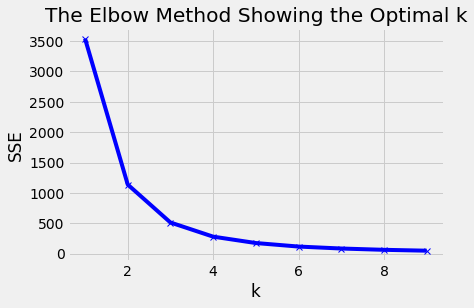

In [45]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c1)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

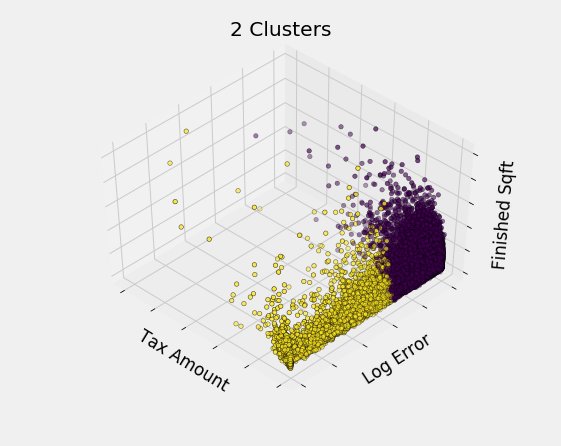

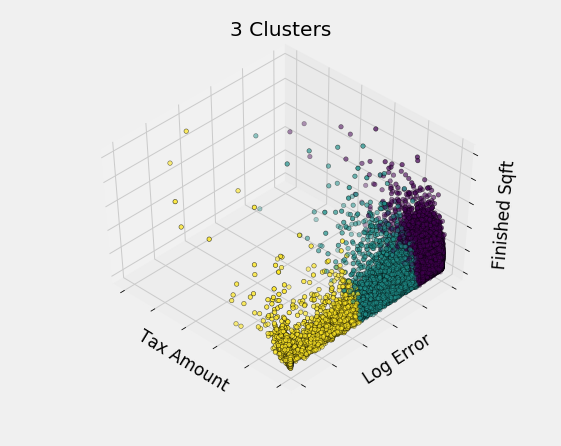

In [46]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c1)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

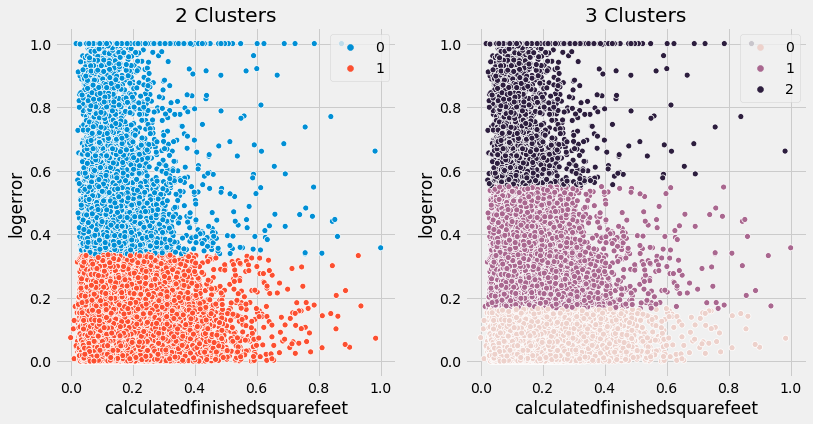

In [47]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c1)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

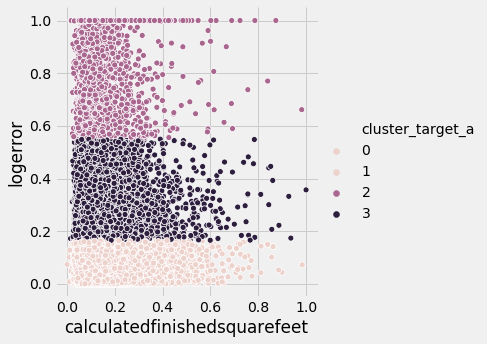

In [48]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c1)
df['cluster_target_a'] = kmeans.predict(df_c1)
df.cluster_target_a = (df.cluster_target_a + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_a')

In [49]:
df.cluster_target_a.value_counts()

1    126158
3     19206
2      4081
Name: cluster_target_a, dtype: int64

In [50]:
kmeans.cluster_centers_

array([[0.05154576],
       [0.82017927],
       [0.27904674]])

In [51]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  
0             Central                 1  
1                None                 3  
2             Central                 1  
3             Central                 1  
5             Central                 3

## Cluster 2 - calculatedfinishedsquarefeet

In [52]:
df_c2 = df[['calculatedfinishedsquarefeet']]

   k         sse
0  1  551.104361
1  2  223.911082
2  3  131.993148
3  4   83.522637
4  5   56.200080
5  6   41.454090
6  7   31.263757
7  8   24.453110
8  9   19.517811


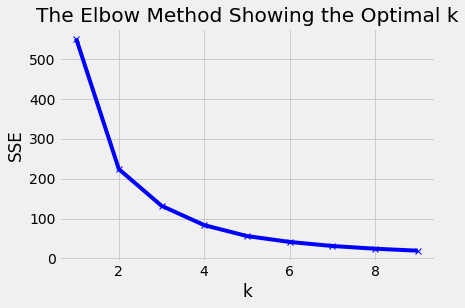

In [53]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c2)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

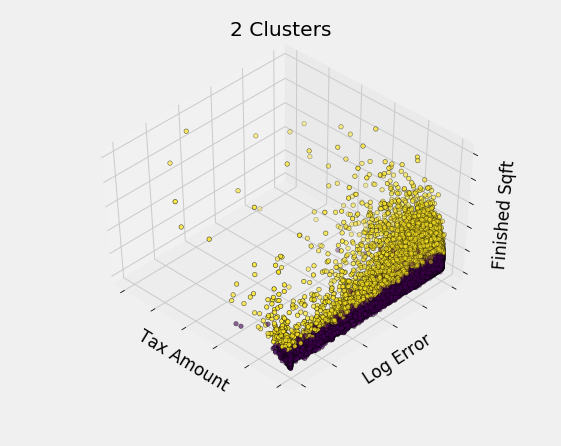

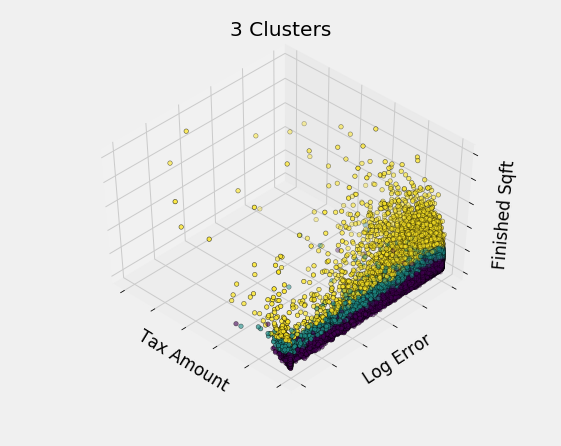

In [54]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c2)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

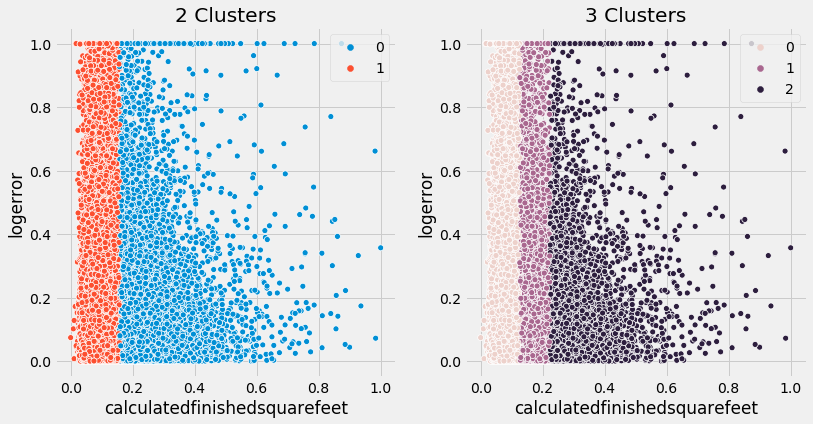

In [55]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c2)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

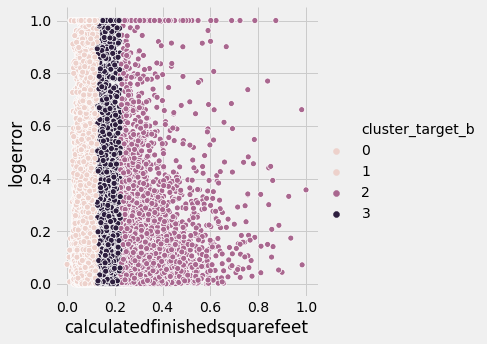

In [56]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c2)
df['cluster_target_b'] = kmeans.predict(df_c2)
df.cluster_target_b = (df.cluster_target_b + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_b')


In [57]:
kmeans.cluster_centers_

array([[0.09002796],
       [0.28485403],
       [0.16112798]])

In [58]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  
0             Central                 1                 1  
1                None                 3                 3  
2             Central                 1                 3  
3             Central                 1                 1  
5             Central                 3                 2

### Cluster 3 - lotsizesquarefeet

In [59]:
df_c3 = df[['lotsizesquarefeet']]

   k         sse
0  1  278.210834
1  2   98.726545
2  3   51.826285
3  4   30.559833
4  5   19.151813
5  6   12.538780
6  7    8.655994
7  8    6.340904
8  9    5.053249


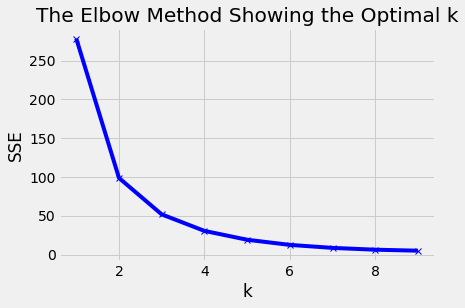

In [60]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c3)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

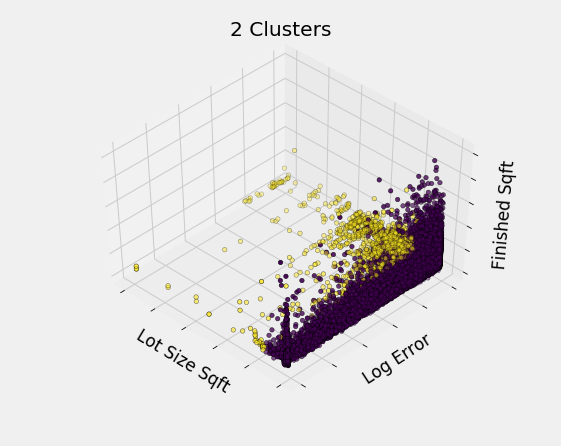

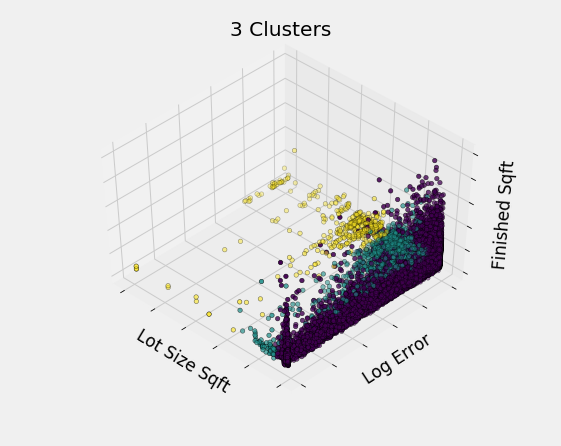

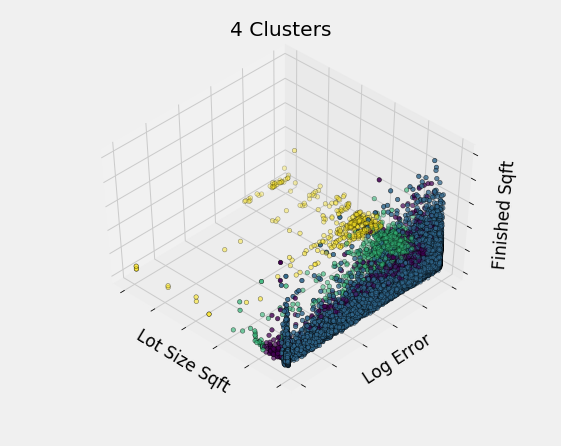

In [61]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3)),
              ('4 Clusters', KMeans(n_clusters=4))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c3)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.lotsizesquarefeet, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Lot Size Sqft')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

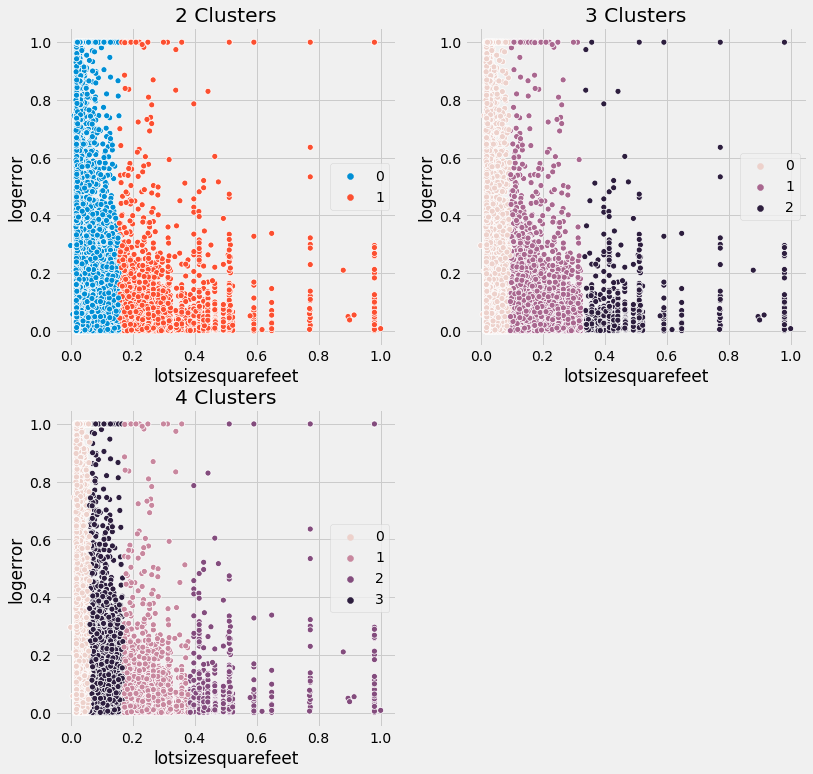

In [62]:
plt.subplots(nrows=1,ncols=2, figsize=(12,12))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c3)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(2, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.lotsizesquarefeet, df.logerror, hue=labels)

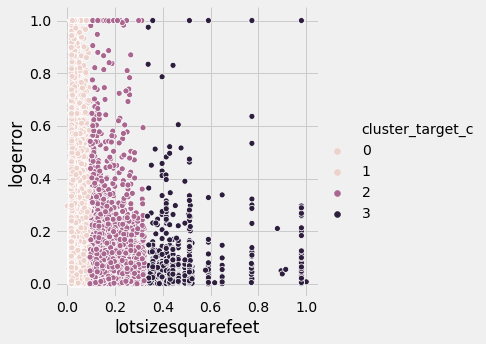

In [63]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c3)
df['cluster_target_c'] = kmeans.predict(df_c3)
df.cluster_target_c = (df.cluster_target_c + 1)
sns.relplot(data=df, x='lotsizesquarefeet', y='logerror', hue='cluster_target_c')


In [64]:
kmeans.cluster_centers_

array([[0.02425134],
       [0.16547367],
       [0.50450305]])

In [65]:
df.head()

logerror transactiondate  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062      2016-01-01         0.10    0.272727                   4.0   
1  0.285610      2016-01-01         0.25    0.363636                   7.0   
2  0.005910      2016-01-01         0.20    0.181818                   4.0   
3  0.036194      2016-01-02         0.10    0.181818                   4.0   
5  0.459316      2016-01-02         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  cluster_target_c  
0             Central                 1                 1                 1  
1                None                 3                 3                 1  
2             Central                 1                 3                 1  
3             Central                 1                 1                 1  
5             Central                 3                 2                 1

### Test the Significance of Clusters

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [67]:
ct_j = df[df['cluster_target_b'] == 1]
ct_k = df[df['cluster_target_b'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -18.037131871480817
p-value: 1.2874793108717965e-72


In [68]:
ct_j = df[df['cluster_target_b'] == 2]
ct_k = df[df['cluster_target_b'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 22.2482098658456
p-value: 3.523813210649526e-109


In [69]:
ct_j = df[df['cluster_target_c'] == 1]
ct_k = df[df['cluster_target_c'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 4.011591610136517
p-value: 6.034019348755757e-05


In [70]:
ct_j = df[df['cluster_target_c'] == 2]
ct_k = df[df['cluster_target_c'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -2.645190924947387
p-value: 0.008187374473391226


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [72]:
df_normal.sample(100)

logerror transactiondate  bathroomcnt  bedroomcnt  \
167613  0.224439      2017-09-19          2.0         3.0   
57866   0.028600      2016-07-20          1.5         2.0   
155209  0.017584      2017-08-09          2.5         2.0   
119762  0.005158      2017-04-25          2.0         3.0   
72946   0.013900      2016-09-02          3.0         3.0   
101037  0.005131      2017-02-17          2.0         2.0   
73312   0.043100      2016-09-06          1.5         2.0   
99600   0.052494      2017-02-10          1.0         1.0   
144122  0.023816      2017-07-03          2.0         3.0   
107820  0.588300      2017-03-16          2.0         2.0   
93033   0.028754      2017-01-13          1.0         2.0   
121308  0.020322      2017-04-28          1.0         2.0   
68875   0.017800      2016-08-23          3.0         4.0   
116480  0.035032      2017-04-13          2.0         2.0   
5192    0.007000      2016-01-26          3.0         4.0   
99412   0.024119      2017-02-10          3.0         3.0   
11255   0.007000      2016-02-23          2.5         3.0   
123174  0.029395      2017-05-04          1.5         2.0   
83988   0.028600      2016-10-11          2.0         3.0   
129460  0.131411      2017-05-24          4.0         5.0   
82014   0.086200      2016-10-03          2.0         1.0   
34454   0.003000      2016-05-12          2.0         3.0   
133878  0.179321      2017-06-06          2.0         4.0   
87926   0.031500      2016-11-21          4.0         4.0   
142062  0.000526      2017-06-29          3.0         3.0   
148300  0.006429      2017-07-18          2.0         3.0   
31085   0.484300      2016-05-02          2.0         3.0   
157979  0.044859      2017-08-17          2.0         2.0   
33338   0.016900      2016-05-09          3.0         4.0   
101490  0.036039      2017-02-21          2.0         3.0   
...          ...             ...          ...         ...   
45926   0.027400      2016-06-15          2.0         3.0   
48371   0.006000      2016-06-22          2.0         3.0   
154025  0.043992      2017-08-04          3.0         4.0   
52118   0.007000      2016-07-01          2.5         3.0   
65645   0.182300      2016-08-12          6.0         5.0   
67876   0.017800      2016-08-19          1.0         1.0   
120800  0.002203      2017-04-27          3.0         5.0   
87978   0.004000      2016-11-21          2.0         2.0   
44417   0.007000      2016-06-10          2.0         2.0   
59054   0.127800      2016-07-25          2.0         2.0   
73582   0.021800      2016-09-07          2.0         3.0   
154600  0.069248      2017-08-08          1.0         1.0   
122389  0.009183      2017-05-02          2.0         2.0   
24260   0.003000      2016-04-11          2.0         3.0   
5013    0.018800      2016-01-26          3.0         4.0   
150443  0.028389      2017-07-25          2.0         3.0   
148004  0.022352      2017-07-17          2.0         4.0   
96731   0.005387      2017-01-30          1.0         3.0   
52864   0.043100      2016-07-06          2.0         3.0   
23285   0.353500      2016-04-07          1.0         4.0   
52975   0.008000      2016-07-06          2.5         3.0   
2911    0.011100      2016-01-15          4.0         5.0   
61882   0.011100      2016-08-01          2.0         2.0   
128660  0.019876      2017-05-22          1.5         3.0   
107413  0.022926      2017-03-15          4.0         5.0   
24186   0.012100      2016-04-11          4.0         3.0   
6264    0.053400      2016-01-29          3.0         3.0   
146993  0.159041      2017-07-13          2.0         2.0   
61510   0.022700      2016-07-29          2.0         2.0   
11978   0.054500      2016-02-25          3.0         3.0   

       buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
167613                   6.0                2.0                        1263.0   
57866                    7.0                1.5                

In [73]:
df_normal.bathroomcnt.value_counts()

2.0     64556
3.0     35308
1.0     27685
2.5     13972
4.0      5397
1.5      3003
3.5      1952
5.0      1712
6.0       625
7.0       191
8.0       101
9.0        28
10.0       11
11.0        3
Name: bathroomcnt, dtype: int64

In [74]:
data_bath_3 = df_normal[df_normal['bathroomcnt'] <= 3.0]
data_bath_4 = df_normal[df_normal['bathroomcnt'] >= 4.0]

stat, p = stats.ttest_ind(data_bath_3['logerror'], data_bath_3['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 0.0
p-value: 1.0


In [75]:
data_bed_3 = df_normal[df_normal['bedroomcnt'] == 3.0]
data_bed_5 = df_normal[df_normal['bedroomcnt'] >= 5.0]

stat, p = stats.ttest_ind(data_bed_3['logerror'], data_bed_5['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

# if p-value is < 0.05, you can reject the null hypothesis

T-stat: -10.165509458956173
p-value: 2.934550723498122e-24


In [76]:
cat_cols

['transactiondate',
 'buildingqualitytypeid',
 'regionidcounty',
 'regionidzip',
 'propertylandusedesc',
 'heatingorsystemdesc']

In [79]:
tbl = pd.crosstab(df["regionidcounty"], df["logerror"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Dependent (reject H0)
0.00017358542114100222


In [81]:
tbl = pd.crosstab(df["regionidcounty"], df["regionidzip"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Dependent (reject H0)
0.0


In [82]:
tbl = pd.crosstab(df["buildingqualitytypeid"], df["heatingorsystemdesc"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Dependent (reject H0)
0.0


In [83]:
tbl = pd.crosstab(df["buildingqualitytypeid"], df["propertylandusedesc"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Dependent (reject H0)
0.0


# Modeling

## Feature Engineering

### Remove variables that are not needed, wanted, or redundant.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [129]:
df = dd.remove_columns(df, cols_to_remove=['transactiondate'])

In [130]:
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

### Add any features you think may be useful.

In [86]:
df_bbroom = df
df_bbroom['bbroom'] = df.bathroomcnt + df.bedroomcnt
df_bbroom.drop(columns=['bathroomcnt', 'bedroomcnt'])

logerror buildingqualitytypeid  calculatedfinishedsquarefeet  \
0       0.046062                   4.0                      0.123713   
1       0.285610                   7.0                      0.166299   
2       0.005910                   4.0                      0.162916   
3       0.036194                   4.0                      0.061562   
5       0.459316                   1.0                      0.225434   
6       0.073964                   7.0                      0.095249   
7       0.277783                   7.0                      0.129523   
8       0.004209                   7.0                      0.058400   
9       0.142527                   7.0                      0.092527   
10      0.649865                   7.0                      0.104075   
11      0.026496                   1.0                      0.226390   
12      0.057631                   7.0                      0.109003   
13      0.137934                   7.0                      0.091718   
14      0.075665                   7.0                      0.100397   
15      0.002508                   7.0                      0.095616   
17      0.070391                   7.0                      0.043763   
18      0.002508                   7.0                      0.097014   
19      0.016118                   4.0                      0.126876   
20      0.064947                   7.0                      0.061636   
21      0.036194                   7.0                      0.108414   
22      0.024455                   7.0                      0.105031   
23      0.194928                   4.0                      0.275596   
24      0.287651                   7.0                      0.089070   
25      0.073964                   7.0                      0.137761   
26      0.126195                   4.0                      0.095616   
28      0.000806                   4.0                      0.076714   
29      0.089956                   4.0                      0.097602   
30      0.066818                   7.0                      0.083995   
31      0.049124                   1.0                      0.104442   
32      0.034493                   7.0                      0.119815   
...          ...                   ...                           ...   
167855  0.057550                   7.0                      0.157326   
167856  0.033848                   8.0                      0.136584   
167858  0.160306                   5.0                      0.070462   
167859  0.109292                   4.0                      0.085172   
167860  0.078650                   7.0                      0.089070   
167861  0.030507                   4.0                      0.061047   
167862  0.002742                   6.0                      0.130332   
167863  1.000000                   4.0                      0.116064   
167864  0.004986                   4.0                      0.060165   
167865  0.060467                   8.0                      0.078553   
167866  0.394180                   9.0                      0.260150   
167868  0.116222                   8.0                      0.092380   
167869  0.000000                   4.0                      0.062813   
167870  0.079862                   8.0                      0.159164   
167871  0.000380                   4.0                      0.075096   
167873  1.000000                   6.0                      0.094072   
167874  0.105274                   6.0                      0.108120   
167875  0.021679                   5.0                      0.045749   
167876  0.088646                   8.0                      0.063695   
167877  0.238790                   4.0                      0.066931   
167878  0.542525                   8.0                      0.151956   
167879  0.047989                  10.0                      0.161665   
167880  0.127496                   8.0                      0.092601   
167881  0.137247                   6.0          

In [87]:
df.head()

logerror  bathroomcnt  bedroomcnt buildingqualitytypeid  \
0  0.046062         0.10    0.272727                   4.0   
1  0.285610         0.25    0.363636                   7.0   
2  0.005910         0.20    0.181818                   4.0   
3  0.036194         0.10    0.181818                   4.0   
5  0.459316         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty regionidzip  yearbuilt  taxamount        propertylandusedesc  \
0         3101.0     96370.0   0.586957   0.020862  Single Family Residential   
1         1286.0     96962.0   0.985507   0.031477  Single Family Residential   
2         3101.0     96293.0   0.449275   0.035613  Single Family Residential   
3         3101.0     96222.0   0.789855   0.009409                Condominium   
5         3101.0     96109.0   0.753623   0.084204  Single Family Residential   

  heatingorsystemdesc  cluster_target_a  cluster_target_b  cluster_target_c  \
0             Central                 1                 1                 1   
1                None                 3                 3                 1   
2             Central                 1                 3                 1   
3             Central                 1                 1                 1   
5             Central                 3                 2                 1   

     bbroom  
0  0.372727  
1  0.613636  
2  0.381818  
3  0.281818  
5  0.663636

In [88]:
df.regionidzip = df.regionidzip.astype(float)

In [89]:
# Copy of the dataframe before taking the absolute value of log errors.
df_nabs = df.copy()

In [90]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

114821    0.009944
830       0.072432
93418     0.065865
142448    0.103764
67098     0.023094
28240     0.065797
95158     0.032219
88240     0.005910
113717    0.054478
107229    0.310657
Name: logerror, dtype: float64

### Train and Test Split

In [117]:
# train_test_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=493)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

X.sample(10)

   bathroomcnt  bedroomcnt buildingqualitytypeid  \
0         0.10    0.272727                   4.0   
1         0.25    0.363636                   7.0   
2         0.20    0.181818                   4.0   
3         0.10    0.181818                   4.0   
5         0.30    0.363636                   1.0   

   calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
0                      0.123713  0.592205   0.513791           0.019867   
1                      0.166299  0.127467   0.936005           0.017900   
2                      0.162916  0.482496   0.677008           0.021838   
3                      0.061562  0.193954   0.607262           0.051922   
5                      0.225434  0.280619   0.558444           0.017427   

  regionidcounty  regionidzip  yearbuilt  taxamount  \
0         3101.0      96370.0   0.586957   0.020862   
1         1286.0      96962.0   0.985507   0.031477   
2         3101.0      96293.0   0.449275   0.035613   
3         3101.0

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


bathroomcnt  bedroomcnt buildingqualitytypeid  \
102384         0.00    0.181818                   4.0   
81514          0.10    0.272727                   7.0   
143436         0.10    0.181818                   7.0   
8406           0.10    0.363636                   4.0   
42213          0.00    0.090909                   4.0   
111406         0.15    0.363636                   7.0   
29729          0.10    0.272727                   7.0   
128020         0.10    0.272727                   6.0   
50368          0.10    0.272727                   7.0   
30355          0.10    0.272727                   7.0   

        calculatedfinishedsquarefeet  latitude  longitude  lotsizesquarefeet  \
102384                      0.053986  0.340802   0.584257           0.018304   
81514                       0.090983  0.203880   0.676409           0.017691   
143436                      0.101942  0.046132   0.951979           0.031925   
8406                        0.148205  0.479373   0.878681           0.021237   
42213                       0.058252  0.486127   0.811866           0.024927   
111406                      0.179317  0.206390   0.878949           0.023750   
29729                       0.093042  0.546216   0.556446           0.019244   
128020                      0.086717  0.914456   0.688464           0.019124   
50368                       0.110400  0.249137   0.750663           0.020310   
30355                       0.113416  0.904493   0.720564           0.019077   

       regionidcounty  regionidzip  yearbuilt  taxamount  \
102384         3101.0      96133.0   0.340580   0.013418   
81514          3101.0      96236.0   0.275362   0.019053   
143436         1286.0      96998.0   0.891304   0.013919   
8406           3101.0      96513.0   0.623188   0.021760   
42213          3101.0      96464.0   0.731884   0.005817   
111406         1286.0      97005.0   0.688406   0.016989   
29729          3101.0      96450.0   0.550725   0.015506   
128020         3101.0      97317.0   0.557971   0.006279   
50368          1286.0      96185.0   0.710145   0.009111   
30355          3101.0      97318.0   0.826087   0.006627   

              propertylandusedesc heatingorsystemdesc  cluster_target_a  \
102384  Single Family Residential          Floor/Wall                 1   
81514   Single Family Residential          Floor/Wall                 1   
143436                Condominium                None                 1   
8406    Single Family Residential             Central                 1   
42213                 Condominium             Central                 1   
111406  Single Family Residential                None                 1   
29729   Single Family Residential             Central                 1   
128020  Single Family Residential             Central                 3   
50368   Single Family Residential                None                 1   
30355   Single Family Residential             Central                 1   

        cluster_target_b  cluster_target_c    bbroom  
102384                 1                 1  0.181818  
81514                  1                 1  0.372727  
143436                 1                 1  0.281818  
8406                   3                 1  0.463636  
42213                  1                 1  0.090909  
111406                 3                 1  0.513636  
29729                  1                 1  0.372727  
128020                 1                 1  0.372727  
50368                  1                 1  0.372727  
30355                  1                 1  0.372727

In [118]:
dd.validate_tts(X_train, y_train, X_test, y_test, train, test)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


## Model Selection

In [119]:
lm1, r2_lm1 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.09146978]
[[0.08176844]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.09
    coefficient (m1): 0.08
Linear Model
  mean_squared_error: 0.0237
  0.10% of the variance in the log error can be explained by the number of square feet.


In [120]:
lm2, r2_lm2 = dd.model_linreg(X_train, y_train, features=['taxamount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.09456486]
[[0.40082453]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.09
    coefficient (m1): 0.40
Linear Model
  mean_squared_error: 0.0236
  0.28% of the variance in the log error can be explained by the number of square feet.


In [121]:
lm3, r2_lm3 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.18331952]
[[ 0.11398642  0.32600629 -0.15492373]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.18
    coefficient (m1): 0.11
Linear Model
  mean_squared_error: 0.023
  2.98% of the variance in the log error can be explained by the number of square feet.


In [122]:
lm4, r2_lm4 = dd.model_linreg(X_train, y_train, features=['calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude', 'lotsizesquarefeet'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.10769357]
[[-0.00155733  0.38986762  0.01384214 -0.02617796 -0.02600061]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
Linear Model
  mean_squared_error: 0.0236
  0.47% of the variance in the log error can be explained by the number of square feet.


In [123]:
lm5, r2_lm5 = dd.model_linreg(X_train, y_train, features=['cluster_target_b'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.10636698]
[[-0.00281379]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
Linear Model
  mean_squared_error: 0.0237
  0.03% of the variance in the log error can be explained by the number of square feet.


In [124]:
lm6, r2_lm6 = dd.model_linreg(X_train, y_train, features=['cluster_target_c'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.10581501]
[[-0.00401461]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
Linear Model
  mean_squared_error: 0.0237
  0.00% of the variance in the log error can be explained by the number of square feet.


In [125]:
lm7, r2_lm7 = dd.model_linreg(X_train, y_train, features=['cluster_target_b', 'cluster_target_c'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.11170658]
[[-0.00290679 -0.00497953]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.11
    coefficient (m1): -0.00
Linear Model
  mean_squared_error: 0.0237
  0.03% of the variance in the log error can be explained by the number of square feet.


In [131]:
X_train.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'taxamount', 'propertylandusedesc', 'heatingorsystemdesc',
       'cluster_target_a', 'cluster_target_b', 'cluster_target_c', 'bbroom'],
      dtype='object')

In [133]:
XX_train = X_train.drop(columns=cat_cols)

In [140]:
XX_train = XX_train.drop(columns='regionidzip')

In [141]:
XX_train.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
yearbuilt                       0
taxamount                       0
cluster_target_a                0
cluster_target_b                0
cluster_target_c                0
bbroom                          0
dtype: int64

In [145]:
lm8 = Ridge(alpha=1.0)
lm8.fit(XX_train, y_train)
lm8.predict(XX_train)
r2_lm8 = lm8.score(XX_train, y_train)
r2_lm8

0.39555963964872953

In [146]:
# Make predictions using the testing set
y_pred_lm3 = lm3.predict(X_test[['calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt']])
mse = mean_squared_error(y_test, y_pred_lm3)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02294558382409541


In [147]:
r2 = r2_score(y_test, y_pred_lm3)
print('{:.2%} of the variance in log errors can be explained by cluster targets a, b, and c.'.format(r2))

3.14% of the variance in log errors can be explained by cluster targets a, b, and c.


Text(0, 0.5, 'Residuals')

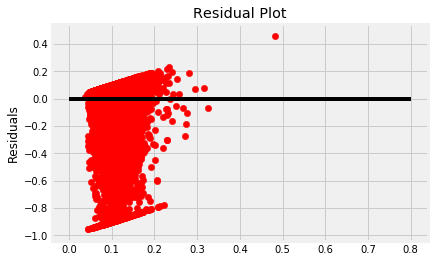

In [148]:
plt.scatter(y_pred_lm3, y_pred_lm3 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')